In [1]:
import findspark
findspark.init()

from pyspark import SparkContext
sc = SparkContext("local", "pyspark-shell")

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

from pyspark.sql.types import StructField, StructType, LongType, StringType, DoubleType
a = StructType([StructField("NO",LongType(),True),StructField("MLSID",StringType(),True),StructField("STREETNUMBERNUMERIC",LongType(),True),StructField("STREETADDRESS",StringType(),True),StructField("STREETNAME",StringType(),True),StructField("POSTALCODE",LongType(),True),StructField("STATEORPROVINCE",StringType(),True),StructField("CITY",StringType(),True),StructField("SALESCLOSEPRICE",LongType(),True),StructField("LISTDATE",StringType(),True),StructField("LISTPRICE",LongType(),True),StructField("LISTTYPE",StringType(),True),StructField("ORIGINALLISTPRICE",LongType(),True),StructField("PRICEPERTSFT",DoubleType(),True),StructField("FOUNDATIONSIZE",LongType(),True),StructField("FENCE",StringType(),True),StructField("MAPLETTER",StringType(),True),StructField("LOTSIZEDIMENSIONS",StringType(),True),StructField("SCHOOLDISTRICTNUMBER",StringType(),True),StructField("DAYSONMARKET",LongType(),True),StructField("OFFMARKETDATE",StringType(),True),StructField("FIREPLACES",LongType(),True),StructField("ROOMAREA4",StringType(),True),StructField("ROOMTYPE",StringType(),True),StructField("ROOF",StringType(),True),StructField("ROOMFLOOR4",StringType(),True),StructField("POTENTIALSHORTSALE",StringType(),True),StructField("POOLDESCRIPTION",StringType(),True),StructField("PDOM",LongType(),True),StructField("GARAGEDESCRIPTION",StringType(),True),StructField("SQFTABOVEGROUND",LongType(),True),StructField("TAXES",LongType(),True),StructField("ROOMFLOOR1",StringType(),True),StructField("ROOMAREA1",StringType(),True),StructField("TAXWITHASSESSMENTS",DoubleType(),True),StructField("TAXYEAR",LongType(),True),StructField("LIVINGAREA",LongType(),True),StructField("UNITNUMBER",StringType(),True),StructField("YEARBUILT",LongType(),True),StructField("ZONING",StringType(),True),StructField("STYLE",StringType(),True),StructField("ACRES",DoubleType(),True),StructField("COOLINGDESCRIPTION",StringType(),True),StructField("APPLIANCES",StringType(),True),StructField("BACKONMARKETDATE",DoubleType(),True),StructField("ROOMFAMILYCHAR",StringType(),True),StructField("ROOMAREA3",StringType(),True),StructField("EXTERIOR",StringType(),True),StructField("ROOMFLOOR3",StringType(),True),StructField("ROOMFLOOR2",StringType(),True),StructField("ROOMAREA2",StringType(),True),StructField("DININGROOMDESCRIPTION",StringType(),True),StructField("BASEMENT",StringType(),True),StructField("BATHSFULL",LongType(),True),StructField("BATHSHALF",LongType(),True),StructField("BATHQUARTER",LongType(),True),StructField("BATHSTHREEQUARTER",DoubleType(),True),StructField("CLASS",StringType(),True),StructField("BATHSTOTAL",LongType(),True),StructField("BATHDESC",StringType(),True),StructField("ROOMAREA5",StringType(),True),StructField("ROOMFLOOR5",StringType(),True),StructField("ROOMAREA6",StringType(),True),StructField("ROOMFLOOR6",StringType(),True),StructField("ROOMAREA7",StringType(),True),StructField("ROOMFLOOR7",StringType(),True),StructField("ROOMAREA8",StringType(),True),StructField("ROOMFLOOR8",StringType(),True),StructField("BEDROOMS",LongType(),True),StructField("SQFTBELOWGROUND",LongType(),True),StructField("ASSUMABLEMORTGAGE",StringType(),True),StructField("ASSOCIATIONFEE",LongType(),True),StructField("ASSESSMENTPENDING",StringType(),True),StructField("ASSESSEDVALUATION",DoubleType(),True)])
df = spark.read.csv("Real_Estate.csv", header=True, schema=a)

# Wrangling with Spark Functions

Failure to account for bad data can set your analysis up to fail.

Dropping the columns requires entering a single column name or passing a list of columns to drop (use * to unpack the list).

Where applies the filter to the dataframe. Like creates a True/False condition for the records. ~ is the not condtion.

For initial pass at the model, it might be helpful to remove large outliers. One definition of an outlier for near normally distributed data is that occurs more than 3 standard deviations from the mean, only 0.3% of data should be filtered. 

Dropna drops missing values. How, thresh, subset...

dropDuplicates() will drop the first duplicate it finds.

### Dropping a list of columns

In [2]:
df.select("STREETNUMBERNUMERIC", "FIREPLACES","LOTSIZEDIMENSIONS","LISTTYPE","ACRES").show(30)

cols_to_drop = ["STREETNUMBERNUMERIC", "LOTSIZEDIMENSIONS"]

df_drop = df.drop(*cols_to_drop)

+-------------------+----------+--------------------+---------------+-----+
|STREETNUMBERNUMERIC|FIREPLACES|   LOTSIZEDIMENSIONS|       LISTTYPE|ACRES|
+-------------------+----------+--------------------+---------------+-----+
|              11511|         0|             279X200|Exclusive Right| 1.28|
|              11200|         0|             100x140|Exclusive Right| 0.32|
|               8583|         0|             120x296|Exclusive Right|0.822|
|               9350|         1|             208X208|Exclusive Right| 0.94|
|               2915|         1|             116x200|Exclusive Right|  0.0|
|               3604|         1|              50x150|Exclusive Right|0.172|
|               9957|         0|              common|Exclusive Right| 0.05|
|               9934|         0|              common|Exclusive Right| 0.05|
|               9926|         0|              common|Exclusive Right| 0.05|
|               9928|         0|              common|Exclusive Right| 0.05|
|           

### Using text filters to remove records


isin() is similar to like() but allows us to pass a list of values to use as a filter rather than a single one.

In [3]:
df_drop.select("ASSUMABLEMORTGAGE").distinct().show()

yes_values = ["Yes w/ Qualifying", "Yes w/No Qualifying"]

text_filter = ~df["ASSUMABLEMORTGAGE"].isin(yes_values) | df["ASSUMABLEMORTGAGE"].isNull()

df_drop = df_drop.filter(text_filter)
df_drop.select("ASSUMABLEMORTGAGE").distinct().show()
print(df_drop.count())

+-------------------+
|  ASSUMABLEMORTGAGE|
+-------------------+
|  Yes w/ Qualifying|
| Information Coming|
|               null|
|Yes w/No Qualifying|
|      Not Assumable|
+-------------------+

+------------------+
| ASSUMABLEMORTGAGE|
+------------------+
|Information Coming|
|              null|
|     Not Assumable|
+------------------+

4976


### Filtering numeric fields conditionally


Exclude any outlier homes that have sold for significantly more or less than the average. Here we will calculate the mean and standard deviation and use them to filer the near normal field log_SalesClosePrice.

In [4]:
from pyspark.sql.functions import mean, stddev, log

df_drop = df_drop.withColumn("log_SalesClosePrice", log("SALESCLOSEPRICE"))

mean_val = df_drop.agg({"log_SalesClosePrice": "mean"}).collect()[0][0]
stddev_val = df_drop.agg({"log_SalesClosePrice": "stddev"}).collect()[0][0]

low_bound = mean_val - (3 * stddev_val)
hi_bound = mean_val + (3 * stddev_val)

df_drop = df_drop.where((df_drop["log_SalesClosePrice"] < hi_bound) & (df_drop["log_SalesClosePrice"] > low_bound))

## Adjusting Data

Real data is ugly and rarely comes ready to be analyzed. Many algorithms and statistical methods have assumptions that a variable conforms to. Mathematical operations can be used to adjust the data. 

One common transformation is scaling. For many algorithms like KNN or regression you need to ensure all your variables are on the same scale. One variable can't be from -1000 to 5000 and another between 0.01 and 0.02. Algorithms will try to reduce the errors in the first variable much more than the second. This can be avoided by scaling each feature between 0 and 1 and this is called **MinMax Scaling**. It doesn't change the shape of the distribution only its range.

To Minmax scale, take the variable subtract the minimum value and divide by the difference between the max and min.

Another common restriction is that the data must closely follow the **standard normal distribution**. Standardization or z-transforming is the process of shifting and scaling your data to better resemble a standard normal distribution which has **mean of 0** and **standard deviation 1**.

To z transform our data, we calculate the aggregate functions mean and std deviation, take the variable subtract the mean value and divide by the std deviation. After these calculations the column would have approximate mean 0 and std deviation of 1.

**Apply log transformation on the data to treat skewed data so data look more like a normal distribution.**

### Custom Percentage Scaling

In [2]:
from pyspark.sql.functions import round

max_days = df.agg({"DAYSONMARKET": "max"}).collect()[0][0]
min_days = df.agg({"DAYSONMARKET": "min"}).collect()[0][0]

df_scaled = df.withColumn("percentagescaleddays", round((df["DAYSONMARKET"] - min_days) / (max_days - min_days))*100)
print(df_scaled.agg({"percentagescaleddays": "max"}).collect())
print(df_scaled.agg({"percentagescaleddays": "min"}).collect())


[Row(max(percentagescaleddays)=100.0)]
[Row(min(percentagescaleddays)=0.0)]


### Scaling your scalers

In [6]:
def min_max_scaler(df, cols_to_scale):
    for col in cols_to_scale:
        max_days = df.agg({col:"max"}).collect()[0][0]
        min_days = df.agg({col:"min"}).collect()[0][0]
        new_column_name = "scaled_" + col
        df = df.withColumn(new_column_name, (df[col] - min_days) / (max_days - min_days))
    return df

cols_to_scale = ['FOUNDATIONSIZE', 'DAYSONMARKET', 'FIREPLACES']

df = min_max_scaler(df, cols_to_scale)

df["DAYSONMARKET", "scaled_DAYSONMARKET"].show()

+------------+--------------------+
|DAYSONMARKET| scaled_DAYSONMARKET|
+------------+--------------------+
|          10|0.044444444444444446|
|           4|0.017777777777777778|
|          28| 0.12444444444444444|
|          19| 0.08444444444444445|
|          21| 0.09333333333333334|
|          17| 0.07555555555555556|
|          32| 0.14222222222222222|
|           5|0.022222222222222223|
|          23| 0.10222222222222223|
|          73|  0.3244444444444444|
|          80| 0.35555555555555557|
|          79|  0.3511111111111111|
|          12| 0.05333333333333334|
|           1|0.004444444444444...|
|          18|                0.08|
|           2|0.008888888888888889|
|          12| 0.05333333333333334|
|          45|                 0.2|
|          31| 0.13777777777777778|
|          16| 0.07111111111111111|
+------------+--------------------+
only showing top 20 rows



### Correcting Right Skew Data


Use log transforms to fix positively skewed data (data whose distribution is mostly to the left). To correct negative skew (data mostly to the right) you need to take an extra step called "reflecting" before you can apply the inverse of **log**, written as (1/log) to make the data look more like normal a normal distribution. Reflecting data uses the following formula to reflect each value: (x_max +1)-x.

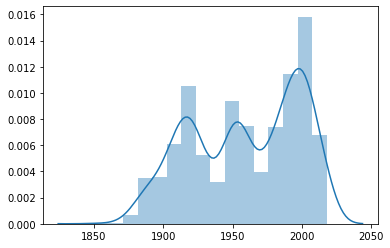

[Row(skewness(YEARBUILT)=-0.2455425013492729)]
+---------+-----------------+
|YEARBUILT|Reflect_YearBuilt|
+---------+-----------------+
|     1950|               69|
|     1971|               48|
|     1949|               70|
|     1960|               59|
|     1978|               41|
|     1965|               54|
|     2015|                4|
|     2017|                2|
|     2017|                2|
|     2017|                2|
|     2017|                2|
|     2017|                2|
|     2017|                2|
|     2016|                3|
|     1977|               42|
|     2017|                2|
|     2017|                2|
|     2017|                2|
|     2017|                2|
|     2017|                2|
+---------+-----------------+
only showing top 20 rows

+---------+-----------------+-------------------+
|YEARBUILT|Reflect_YearBuilt|      adj_yearbuilt|
+---------+-----------------+-------------------+
|     1950|               69|0.23617733727628992|
|     1

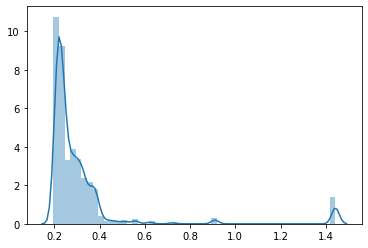

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sample_df = df.select("YEARBUILT").sample(False, 0.5, 42)
pandas_df = sample_df.toPandas()

sns.distplot(pandas_df)
plt.show()

from pyspark.sql.functions import skewness
print(df.agg({"YEARBUILT": "skewness"}).collect())

max_year = df.agg({"YEARBUILT": "max"}).collect()[0][0]
df_reflect = df.withColumn("Reflect_YearBuilt", (max_year + 1) - df["YEARBUILT"])

df_reflect.select("YEARBUILT", "Reflect_YearBuilt").show()

df_reflect = df_reflect.withColumn("adj_yearbuilt", 1 / log(df_reflect["Reflect_YearBuilt"]))

df_reflect.select("YEARBUILT", "Reflect_YearBuilt", "adj_yearbuilt").show()

sample_df = df_reflect.select("adj_yearbuilt").sample(False, 0.5, 42)
pandas_df = sample_df.toPandas()
sns.distplot(pandas_df)
plt.show()


## Working with Missing Data

Understanding why your data is missing is important. If data has a few missing values and they are missing completely at random it may be fine to removo the rows. You can use isNull() and count the missing values. Also you can use heatmap function to visualize missing values. 

Another way to handle them is to replace them. Use logic to replace with 0, mean or median. Replacing values shouldn't be done without some serious considerations.

To replace missing values use PySpark's fillna.

### Visualizing Missing Data

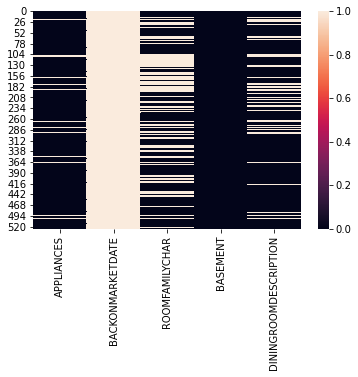

In [8]:
columns = ['APPLIANCES',
 'BACKONMARKETDATE',
 'ROOMFAMILYCHAR',
 'BASEMENT',
 'DININGROOMDESCRIPTION']

df_sample = df.select(columns).sample(False, 0.1, 42)
sample_df = df_sample.toPandas()
tf_df = sample_df.isnull()

sns.heatmap(data=tf_df)
plt.show()


### Imputing Missing Data

In [9]:
from pyspark.sql.functions import when, col
from pyspark.sql.types import NullType

df_miss = df.withColumn("PDOM",
    when(col("NO") == 26,
        None
    ).when(col("NO") == 27,
        None
    ).when(col("NO") == 28,
        None
    ).when(col("NO") == 29,
        None
    ).when(col("NO") == 30,
        None
    ).when(col("NO") == 31,
        None
    ).when(col("NO") == 32,
        None
    ).when(col("NO") == 33,
        None
    ).when(col("NO") == 34,
        None
    ).otherwise(col("PDOM")))

missing = df_miss.where(df_miss["PDOM"].isNull()).count()
print(missing)
col_mean = df_miss.agg({"PDOM": "mean"}).collect()[0][0]
df_miss = df_miss.fillna(col_mean, subset=["PDOM"])
missing = df_miss.where(df_miss["PDOM"].isNull()).count()
print(missing)

9
0


### Calculate Missing Percents

In [10]:
def column_dropper(df, threshold):
    total_records = df.count()
    for col in df.columns:
        missing = df.where(df[col].isNull()).count()
        missing_percent = missing / total_records
        if missing_percent > threshold:
            print(col)
            df = df.drop(col)
    return df

print(len(df.columns))

df = column_dropper(df, 0.6)

print(len(df.columns))

77
POOLDESCRIPTION
UNITNUMBER
BACKONMARKETDATE
ROOMAREA8
ROOMFLOOR8
ASSUMABLEMORTGAGE
71


### Getting More Data

Adding external data may add excellent predictors for a model but adding too many features may impact the performance of the model. External data can be a great way to replace missing or aggregated values with a better feature but it is easy to induce data leakage.

There are many ways to join data together. The most commonly the inner or left joins depending on your goals. 

With SparkSQL you can apply SQL statements directly to dataframes and join tables.

### A Dangerous Join


Original data had no latitude and longitude columns these are added. Also, walk_df was not provided. So, a csv file was created for that and datatypes were handled.

In [3]:
from pyspark.sql.functions import when, col

walk_df = spark.read.csv("walk.csv", header=True)
walk_df = walk_df.withColumn("bikescore", when(walk_df.bikescore == "NaN", None).otherwise(col("bikescore")))
walk_df = walk_df.withColumn("transitscore", when(walk_df.transitscore == "NaN", None).otherwise(col("transitscore")))

walk_df = walk_df.withColumn("bikescore", walk_df.bikescore.cast("int"))
walk_df = walk_df.withColumn("walkscore", walk_df.walkscore.cast("int"))
walk_df = walk_df.withColumn("longitude", walk_df.longitude.cast("double"))
walk_df = walk_df.withColumn("latitude", walk_df.latitude.cast("double"))
walk_df.show()

print(walk_df.dtypes)
print(walk_df.count())

+--------+---------+---------+---------+------------+
|latitude|longitude|walkscore|bikescore|transitscore|
+--------+---------+---------+---------+------------+
|44.92635|-93.18928|       61|       72|        None|
| 44.9581|-93.17982|       74|       83|        None|
|44.93788|-93.12767|       84|       73|        None|
|44.93071|-93.09431|       48|       60|        None|
|44.97547| -93.0679|       83|       53|        None|
|44.98683|-93.03703|       37|       48|        None|
|44.97599| -93.0087|        6|       48|        None|
|45.02617|-92.97972|       30|     null|        None|
|44.89481|-92.93888|        4|     null|        None|
|44.90495|-92.91649|        3|     null|        None|
|44.87344|-92.91489|        0|     null|        None|
|44.98808|-93.14601|       63|       66|        None|
|44.97113| -93.1278|       50|       69|        None|
|44.94951|-93.12778|       81|       63|        None|
|44.92445|-93.09533|       53|       40|        None|
|44.93154|-93.09249|       5

In [35]:
from pyspark.sql.functions import monotonically_increasing_id
ll = spark.read.csv("latitude_longitude.csv", header = True)
ll = ll.withColumn("NO",monotonically_increasing_id()+1)
df_ll = df.join(ll, on="NO")
df_ll = df_ll.withColumn("latitude", df_ll.latitude.cast("double"))
df_ll = df_ll.withColumn("longitude", df_ll.longitude.cast("double"))
df_ll = df_ll.withColumn("latitude", round(df_ll.latitude,5))
df_ll = df_ll.withColumn("longitude", round(df_ll.longitude,5))

In [18]:
condition =  [walk_df["longitude"] == df_ll["longitude"], walk_df["latitude"] == df_ll["latitude"]]
join_df = df_ll.join(walk_df, on = condition, how="left")
print(join_df.where(~join_df["walkscore"].isNull()).count())

4448


### Spark SQL Join


In [22]:
df_ll.createOrReplaceTempView("df")
walk_df.createOrReplaceTempView("walk_df")

join_sql = """SELECT *
              FROM df
              LEFT JOIN walk_df
              ON df.longitude = walk_df.longitude AND df.latitude = walk_df.latitude"""
joined_df = spark.sql(join_sql)

In [23]:
print(joined_df.where(~joined_df["walkscore"].isNull()).count())

4448


### Checking for Bad Joins


In [37]:
from pyspark.sql.functions import monotonically_increasing_id
ll = spark.read.csv("latitude_longitude.csv", header = True)
ll = ll.withColumn("NO",monotonically_increasing_id()+1)
df_orig = df.join(ll, on="NO")
df_orig = df_orig.withColumn("latitude", df_orig.latitude.cast("double"))
df_orig = df_orig.withColumn("longitude", df_orig.longitude.cast("double"))

In [46]:
wrong_prec_cond = [walk_df["longitude"] == df_orig["longitude"],walk_df["latitude"] == df_orig["latitude"]]
wrong_prec_df = df_orig.join(walk_df, on=wrong_prec_cond, how="left")

print(wrong_prec_df.where(wrong_prec_df["walkscore"].isNull()).count())
print(joined_df.where(joined_df["walkscore"].isNull()).count())

few_keys_cond = [walk_df["longitude"] == df_ll["longitude"]]
few_keys_df = df_ll.join(walk_df, on=few_keys_cond, how="left")

print("Record Count of the Too Few Keys Join Example: " + str(few_keys_df.count()))
print("Record Count of the Correct Join Example: " + str(joined_df.count()))

4958
552
Record Count of the Too Few Keys Join Example: 6104
Record Count of the Correct Join Example: 5000
